In [46]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler


from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance, SilhouetteVisualizer

from kneed import KneeLocator

import seaborn as sns

In [47]:
#perform cyclic encoding
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

## Pre-process Customers

In [48]:
customers= pd.read_excel("Adventure Works_Database.xlsx", sheet_name="Sheet3")
customers.head()

,CustomerKey,FirstName,LastName,FullName,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,AddressLine1,DateFirstPurchase,CommuteDistance
0,11000,Jon,Yang,"Yang, Jon",1966-04-08,M,M,90000,2,0,Bachelors,Professional,1,0,3761 N. 14th St,2014-01-22,1-2 Miles
1,11001,Eugene,Huang,"Huang, Eugene",1965-05-14,S,M,60000,3,3,Bachelors,Professional,0,1,2243 W St.,2014-01-18,0-1 Miles
2,11002,Ruben,Torres,"Torres, Ruben",1965-08-12,M,M,60000,3,3,Bachelors,Professional,1,1,5844 Linden Land,2014-01-10,2-5 Miles
3,11003,Christy,Zhu,"Zhu, Christy",1968-02-15,S,F,70000,0,0,Bachelors,Professional,0,1,1825 Village Pl.,2014-01-01,5-10 Miles
4,11004,Elizabeth,Johnson,"Johnson, Elizabeth",1968-08-08,S,F,80000,5,5,Bachelors,Professional,1,4,7553 Harness Circle,2014-01-26,1-2 Miles


In [49]:
customers.drop(columns=['FullName', 'AddressLine1', 'FirstName', 'LastName'], inplace=True)
customers.head()

,CustomerKey,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance
0,11000,1966-04-08,M,M,90000,2,0,Bachelors,Professional,1,0,2014-01-22,1-2 Miles
1,11001,1965-05-14,S,M,60000,3,3,Bachelors,Professional,0,1,2014-01-18,0-1 Miles
2,11002,1965-08-12,M,M,60000,3,3,Bachelors,Professional,1,1,2014-01-10,2-5 Miles
3,11003,1968-02-15,S,F,70000,0,0,Bachelors,Professional,0,1,2014-01-01,5-10 Miles
4,11004,1968-08-08,S,F,80000,5,5,Bachelors,Professional,1,4,2014-01-26,1-2 Miles


In [50]:
customers.dtypes

CustomerKey                      int64
BirthDate               datetime64[ns]
MaritalStatus                   object
Gender                          object
YearlyIncome                     int64
TotalChildren                    int64
NumberChildrenAtHome             int64
Education                       object
Occupation                      object
HouseOwnerFlag                   int64
NumberCarsOwned                  int64
DateFirstPurchase       datetime64[ns]
CommuteDistance                 object
dtype: object

In [51]:
customers['CommuteDistance'].value_counts()

0-1 Miles     6310
2-5 Miles     3234
1-2 Miles     3232
5-10 Miles    3214
10+ Miles     2494
Name: CommuteDistance, dtype: int64

In [52]:
# map CommuteDistance
map = {'0-1 Miles':0,'1-2 Miles':1,  '2-5 Miles':2,'5-10 Miles':5, '10+ Miles':10}
customers['CommuteDistance'].replace(map, inplace=True)

In [53]:
object = customers.select_dtypes(include=['object']).columns

# convert to category type first and extract codes e. g. F-> 0, M -> 1 etc.
customers[object] = customers[object].apply(lambda x: x.astype('category'))

In [54]:
categorical = customers.select_dtypes(include=['category']).columns
customers[categorical] = customers[categorical].apply(lambda x: x.cat.codes)

In [55]:
customers.dtypes

CustomerKey                      int64
BirthDate               datetime64[ns]
MaritalStatus                     int8
Gender                            int8
YearlyIncome                     int64
TotalChildren                    int64
NumberChildrenAtHome             int64
Education                         int8
Occupation                        int8
HouseOwnerFlag                   int64
NumberCarsOwned                  int64
DateFirstPurchase       datetime64[ns]
CommuteDistance                  int64
dtype: object

In [56]:
customers.head()

,CustomerKey,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance
0,11000,1966-04-08,0,1,90000,2,0,0,3,1,0,2014-01-22,1
1,11001,1965-05-14,1,1,60000,3,3,0,3,0,1,2014-01-18,0
2,11002,1965-08-12,0,1,60000,3,3,0,3,1,1,2014-01-10,2
3,11003,1968-02-15,1,0,70000,0,0,0,3,0,1,2014-01-01,5
4,11004,1968-08-08,1,0,80000,5,5,0,3,1,4,2014-01-26,1


In [57]:
customers['DateFirstPurchase_month'] = customers['DateFirstPurchase'].dt.month
customers = encode(customers, 'DateFirstPurchase_month', 12)

customers['DateFirstPurchase_year'] = customers['DateFirstPurchase'].dt.year

customers['BirthDate_month'] = customers['BirthDate'].dt.month
customers = encode(customers, 'BirthDate_month', 12)

customers['BirthDate_year'] = customers['BirthDate'].dt.year

In [58]:
customers.drop(columns=['DateFirstPurchase_month', 'BirthDate_month','BirthDate', 'DateFirstPurchase'], inplace=True)
customers.head()

,CustomerKey,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,CommuteDistance,DateFirstPurchase_month_sin,DateFirstPurchase_month_cos,DateFirstPurchase_year,BirthDate_month_sin,BirthDate_month_cos,BirthDate_year
0,11000,0,1,90000,2,0,0,3,1,0,1,0.5,0.866025,2014.0,0.866025,-0.500000,1966
1,11001,1,1,60000,3,3,0,3,0,1,0,0.5,0.866025,2014.0,0.500000,-0.866025,1965
2,11002,0,1,60000,3,3,0,3,1,1,2,0.5,0.866025,2014.0,-0.866025,-0.500000,1965
3,11003,1,0,70000,0,0,0,3,0,1,5,0.5,0.866025,2014.0,0.866025,0.500000,1968
4,11004,1,0,80000,5,5,0,3,1,4,1,0.5,0.866025,2014.0,-0.866025,-0.500000,1968


In [59]:
X_customers = customers.copy()

# drop CustomerKey to avoid overfitting
X_customers.drop(columns=['CustomerKey'], inplace=True)

scaler = StandardScaler()
X_customers = scaler.fit_transform(customers)

X_customers = pd.DataFrame(X_customers, columns=customers.columns)
X_customers.head()

,CustomerKey,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,CommuteDistance,DateFirstPurchase_month_sin,DateFirstPurchase_month_cos,DateFirstPurchase_year,BirthDate_month_sin,BirthDate_month_cos,BirthDate_year
0,-1.731957,-0.919983,0.988275,1.012676,0.096534,-0.659428,-1.243552,0.488316,0.691725,-1.320058,-0.521238,0.750366,1.263241,-2.246745,1.211420,-0.625738,0.392931
1,-1.731770,1.086976,0.988275,0.083451,0.716741,1.310862,-1.243552,0.488316,-1.445661,-0.441603,-0.820206,0.750366,1.263241,-2.246745,0.711499,-1.166820,0.304034
2,-1.731582,-0.919983,0.988275,0.083451,0.716741,1.310862,-1.243552,0.488316,0.691725,-0.441603,-0.222269,0.750366,1.263241,-2.246745,-1.154234,-0.625738,0.304034
3,-1.731395,1.086976,-1.011864,0.393193,-1.143880,-0.659428,-1.243552,0.488316,-1.445661,-0.441603,0.674636,0.750366,1.263241,-2.246745,1.211420,0.852524,0.570727
4,-1.731207,1.086976,-1.011864,0.702935,1.957156,2.624389,-1.243552,0.488316,0.691725,2.193760,-0.521238,0.750366,1.263241,-2.246745,-1.154234,-0.625738,0.570727


In [60]:
X_customers.isna().sum()

CustomerKey                      0
MaritalStatus                    0
Gender                           0
YearlyIncome                     0
TotalChildren                    0
NumberChildrenAtHome             0
Education                        0
Occupation                       0
HouseOwnerFlag                   0
NumberCarsOwned                  0
CommuteDistance                  0
DateFirstPurchase_month_sin    566
DateFirstPurchase_month_cos    566
DateFirstPurchase_year         566
BirthDate_month_sin              0
BirthDate_month_cos              0
BirthDate_year                   0
dtype: int64

In [61]:
X_customers['DateFirstPurchase_month_sin'].fillna(0, inplace=True)
X_customers['DateFirstPurchase_month_cos'].fillna(0, inplace=True)
X_customers['DateFirstPurchase_year'].fillna(0, inplace=True)

In [62]:
X_customers.isna().sum()

CustomerKey                    0
MaritalStatus                  0
Gender                         0
YearlyIncome                   0
TotalChildren                  0
NumberChildrenAtHome           0
Education                      0
Occupation                     0
HouseOwnerFlag                 0
NumberCarsOwned                0
CommuteDistance                0
DateFirstPurchase_month_sin    0
DateFirstPurchase_month_cos    0
DateFirstPurchase_year         0
BirthDate_month_sin            0
BirthDate_month_cos            0
BirthDate_year                 0
dtype: int64

In [63]:
transactions= pd.read_excel("Adventure Works_Database.xlsx", sheet_name="Sheet5")
transactions = transactions[transactions["OrderDate"].between("2016-01-01", "2016-12-31")]
transactions.head()

,ProductKey,OrderDate,ShipDate,CustomerKey,PromotionKey,SalesTerritoryKey,SalesOrderNumber,SalesOrderLineNumber,OrderQuantity,UnitPrice,TotalProductCost,SalesAmount,TaxAmt
5428,380,2016-01-01,2016-01-08,18239,1,9,SO51176,1,1,2443.35,1554.9479,2443.35,195.4680
5429,479,2016-01-01,2016-01-08,18239,1,9,SO51176,2,1,8.99,3.3623,8.99,0.7192
5430,577,2016-01-01,2016-01-08,27873,1,9,SO51177,1,1,1214.85,755.1508,1214.85,97.1880
5431,217,2016-01-01,2016-01-08,27873,1,9,SO51177,2,1,34.99,13.0863,34.99,2.7992
5432,353,2016-01-01,2016-01-08,11245,2,8,SO51178,1,1,2319.99,1265.6195,2319.99,185.5992


In [64]:
sales_by_customer = transactions.groupby("CustomerKey").sum()
sales_by_customer = sales_by_customer[["SalesAmount", "OrderQuantity"]]
sales_by_customer.head()

,SalesAmount,OrderQuantity
CustomerKey,,
11000,4849.00,7
11001,3008.89,16
11002,4714.05,3
11003,4739.30,8
11004,4796.02,7


In [65]:
customers.head()

,CustomerKey,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,CommuteDistance,DateFirstPurchase_month_sin,DateFirstPurchase_month_cos,DateFirstPurchase_year,BirthDate_month_sin,BirthDate_month_cos,BirthDate_year
0,11000,0,1,90000,2,0,0,3,1,0,1,0.5,0.866025,2014.0,0.866025,-0.500000,1966
1,11001,1,1,60000,3,3,0,3,0,1,0,0.5,0.866025,2014.0,0.500000,-0.866025,1965
2,11002,0,1,60000,3,3,0,3,1,1,2,0.5,0.866025,2014.0,-0.866025,-0.500000,1965
3,11003,1,0,70000,0,0,0,3,0,1,5,0.5,0.866025,2014.0,0.866025,0.500000,1968
4,11004,1,0,80000,5,5,0,3,1,4,1,0.5,0.866025,2014.0,-0.866025,-0.500000,1968


In [66]:
customers = customers.join(sales_by_customer, on="CustomerKey", how="left")
customers[["SalesAmount", "OrderQuantity"]] = customers[["SalesAmount", "OrderQuantity"]].fillna(0)

customers.head()

,CustomerKey,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,CommuteDistance,DateFirstPurchase_month_sin,DateFirstPurchase_month_cos,DateFirstPurchase_year,BirthDate_month_sin,BirthDate_month_cos,BirthDate_year,SalesAmount,OrderQuantity
0,11000,0,1,90000,2,0,0,3,1,0,1,0.5,0.866025,2014.0,0.866025,-0.500000,1966,4849.00,7.0
1,11001,1,1,60000,3,3,0,3,0,1,0,0.5,0.866025,2014.0,0.500000,-0.866025,1965,3008.89,16.0
2,11002,0,1,60000,3,3,0,3,1,1,2,0.5,0.866025,2014.0,-0.866025,-0.500000,1965,4714.05,3.0
3,11003,1,0,70000,0,0,0,3,0,1,5,0.5,0.866025,2014.0,0.866025,0.500000,1968,4739.30,8.0
4,11004,1,0,80000,5,5,0,3,1,4,1,0.5,0.866025,2014.0,-0.866025,-0.500000,1968,4796.02,7.0


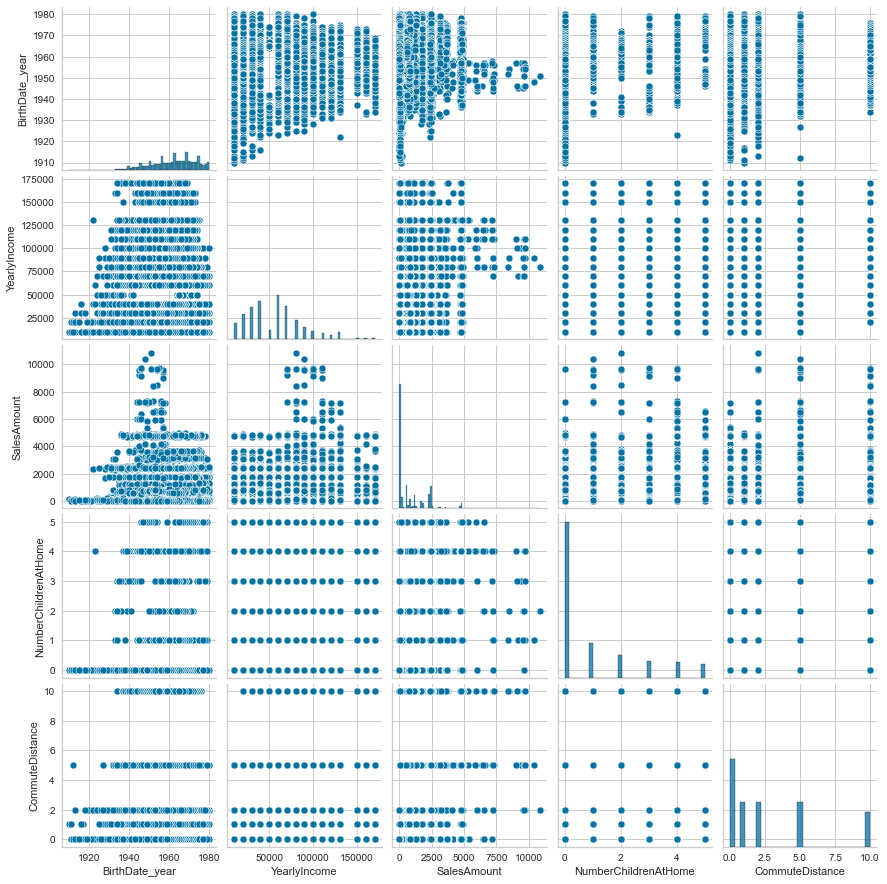

In [67]:
sns.pairplot(customers[["BirthDate_year", "YearlyIncome", "SalesAmount", "NumberChildrenAtHome", "CommuteDistance"]])

### K-means

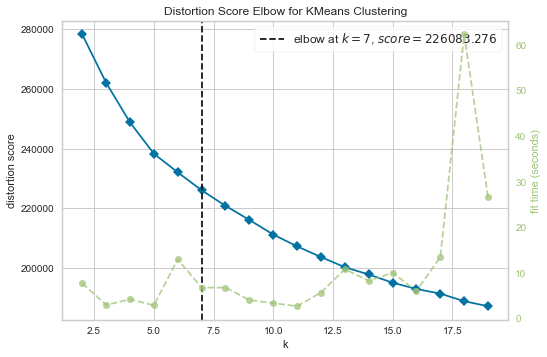

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [68]:
# Instantiate the clustering model and visualizer
kmeans = KMeans(random_state=42)
visualizer = KElbowVisualizer(kmeans, k=(2,20))

visualizer.fit(X_customers)
visualizer.show()  

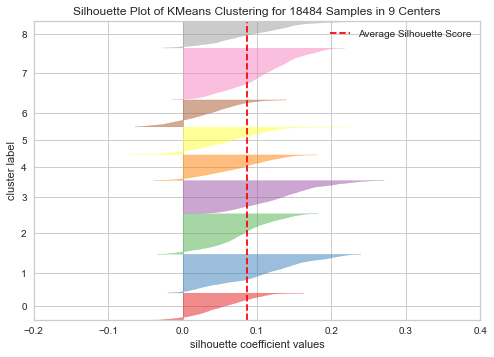

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 18484 Samples in 9 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [69]:
kmeans = KMeans(random_state=42, n_clusters=9)
visualizer = SilhouetteVisualizer(kmeans)
visualizer.fit(X_customers)       
visualizer.show()  

### K-means Batch

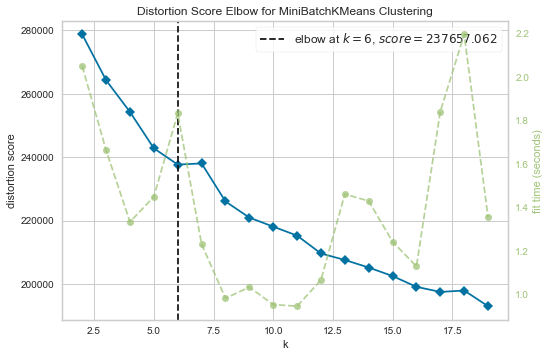

<AxesSubplot:title={'center':'Distortion Score Elbow for MiniBatchKMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [70]:
# Instantiate the clustering model and visualizer
kmeans_batch = MiniBatchKMeans(batch_size=2048, random_state=42)
visualizer = KElbowVisualizer(kmeans_batch, k=(2,20))

visualizer.fit(X_customers)
visualizer.show()  

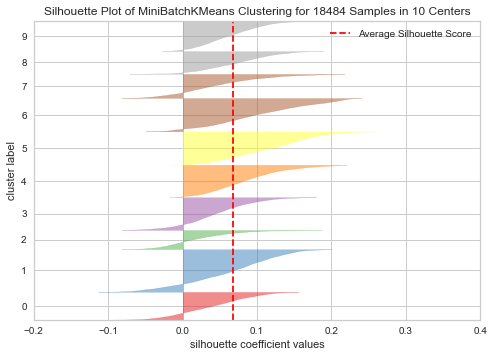

<AxesSubplot:title={'center':'Silhouette Plot of MiniBatchKMeans Clustering for 18484 Samples in 10 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [71]:
kmeans_batch = MiniBatchKMeans(batch_size=2048, random_state=42, n_clusters=10)
visualizer = SilhouetteVisualizer(kmeans_batch, is_fitted=True)

visualizer.fit(X_customers)       
visualizer.show()  

## DBSCAN

Text(0, 0.5, 'Distance')

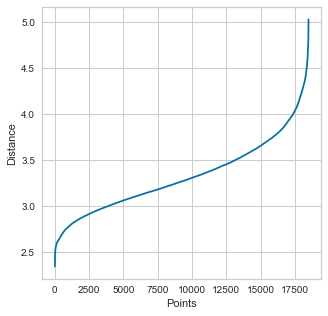

In [72]:
# see here: https://machinelearningknowledge.ai/tutorial-for-dbscan-clustering-in-python-sklearn/
n = 128

nearest_neighbors = NearestNeighbors(n_neighbors=n)
neighbors = nearest_neighbors.fit(X_customers)

distances, indices = neighbors.kneighbors(X_customers)
# get distance to nth neighbour
distances = np.sort(distances[:,n-1], axis=0)

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

3.7574769216525143


<Figure size 360x360 with 0 Axes>

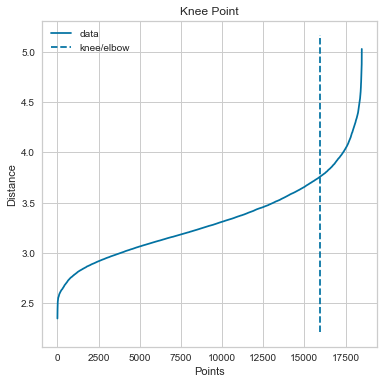

In [73]:
# Find epsilon value
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

eps = distances[knee.knee]
print(eps)

In [74]:
dbscan = DBSCAN(eps=eps, min_samples=10)
dbscan.fit(X_customers)

DBSCAN(eps=3.7574769216525143, min_samples=10)

## Final comparison

In [75]:
customers['class_kmeans'] = kmeans.predict(X_customers)
customers['class_kmeans_batch'] = kmeans_batch.predict(X_customers)
customers['class_dbscan'] = dbscan.labels_
customers.head(10)

,CustomerKey,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,Education,Occupation,HouseOwnerFlag,NumberCarsOwned,...,DateFirstPurchase_month_cos,DateFirstPurchase_year,BirthDate_month_sin,BirthDate_month_cos,BirthDate_year,SalesAmount,OrderQuantity,class_kmeans,class_kmeans_batch,class_dbscan
0,11000,0,1,90000,2,0,0,3,1,0,...,0.866025,2014.0,8.660254e-01,-0.500000,1966,4849.00,7.0,6,7,0
1,11001,1,1,60000,3,3,0,3,0,1,...,0.866025,2014.0,5.000000e-01,-0.866025,1965,3008.89,16.0,6,0,0
2,11002,0,1,60000,3,3,0,3,1,1,...,0.866025,2014.0,-8.660254e-01,-0.500000,1965,4714.05,3.0,6,7,0
3,11003,1,0,70000,0,0,0,3,0,1,...,0.866025,2014.0,8.660254e-01,0.500000,1968,4739.30,8.0,6,0,0
4,11004,1,0,80000,5,5,0,3,1,4,...,0.866025,2014.0,-8.660254e-01,-0.500000,1968,4796.02,7.0,8,1,0
5,11005,1,1,70000,0,0,0,3,1,1,...,0.866025,2014.0,-8.660254e-01,-0.500000,1965,4746.34,12.0,6,7,0
6,11006,1,0,70000,0,0,0,3,1,1,...,0.866025,2014.0,-2.449294e-16,1.000000,1965,4719.04,4.0,6,7,0
7,11007,0,1,60000,3,3,0,3,1,2,...,0.866025,2014.0,5.000000e-01,-0.866025,1964,4811.01,7.0,6,7,0
8,11008,1,0,60000,4,4,0,3,1,3,...,0.866025,2014.0,-5.000000e-01,-0.866025,1964,4731.32,18.0,8,1,0
9,11009,1,1,70000,0,0,0,3,0,1,...,0.866025,2014.0,8.660254e-01,-0.500000,1964,4716.34,10.0,6,0,0


In [76]:
customers['class_dbscan'].value_counts()

 0    18482
-1        2
Name: class_dbscan, dtype: int64

In [77]:
customers.to_excel("customers_with_class.xlsx")

In [78]:
%%script false --no-raise-error


# plot the results, exclude last 3 label columns, restrict to sample of 100
sample_size = 100

for i in range(customers.shape[1]-4):
    plt.figure()
    sns.swarmplot(x=customers.columns[i], y=customers.columns[i+1], hue="class_kmeans", data=customers[0:sample_size])
    #plt.scatter(customers[customers.columns[i]], customers[customers.columns[i+1]], c=customers['class_kmeans'], s=customers['class_kmeans'], cmap="Set1")
    plt.title(f"{customers.columns[i]} vs. {customers.columns[i+1]}, KNN")
    plt.show()
    plt.figure()
    sns.swarmplot(x=customers.columns[i], y=customers.columns[i+1], hue="class_kmeans_batch", data=customers[0:sample_size])
    #plt.scatter(customers[customers.columns[i]], customers[customers.columns[i+1]], c=customers['class_kmeans_batch'], s=customers['class_kmeans_batch'], cmap="Set1")
    plt.title(f"{customers.columns[i]} vs. {customers.columns[i+1]}, KNN Batch")
    plt.show()
    plt.figure()
    sns.swarmplot(x=customers.columns[i], y=customers.columns[i+1], hue="class_dbscan", data=customers[0:sample_size])
    #plt.scatter(customers[customers.columns[i]], customers[customers.columns[i+1]], c=customers['class_dbscan'], s=customers['class_dbscan'], cmap="Set1")
    plt.title(f"{customers.columns[i]} vs. {customers.columns[i+1]}, DBSCAN")
    plt.show()


Couldn't find program: 'false'
